# SimEx VSL
For running SUMO adjuste the path in the global_settings.py file.

In [1]:
# IMPORT LIBRARIES
import numpy as np

from components_configuration import components
from global_settings import simexSettings,mds

from validator_controller import ValidatorController
from modifier_controller import ModifierController
from simulator_controller import SimulatorController
from logger_utils import Logger

import pickle
import datetime
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

validator_controller_vsl = ValidatorController("VSL")
logger = Logger()
logger_main_arguments = {}
is_main_func = True
# Initialize interval list for the first iteration
intervals_list=[[mds['domain_min_interval'], mds['domain_max_interval']]]
#intervals_list=[[2900, 3200]]
# Timestamp for the validator pickle file
count = 0
filename1 = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

while is_main_func:
    
    # Calls Modifier Controller
    mod_outcome = ModifierController.control(intervals_list=intervals_list,selected_modifier=components['modifierA'], do_plot=simexSettings['do_plot'])
    mod_x_list = mod_outcome[0]
    checked_intervals = mod_outcome[1]
    print("MAIN mod outcome", mod_outcome)  

    
    # breaks loop if iterations end by granularity reached
    if not mod_x_list: # FALSE IF ['modifier_data_point'] < mdv['modifier_incremental_unit']:
        logger_main_arguments['log_contex'] = 'overall MAIN stats'
        logger_main_arguments['main_status'] = 'no generated points'
        logger_main_arguments['remaining_unfit_intervals'] = checked_intervals
        logger.log_main(logger_main_arguments)
        break
    
    # Calls Simulator
    mod_x,sim_y_list = SimulatorController.simulate(mod_x_list,selected_simulator=components['sumo_simulator_vsl'])
    print(f"MODX {mod_x} and sim_y_list {sim_y_list}")
    assert len(mod_x) == len(sim_y_list)

    print("MAIN modx", mod_x)  

    # Calls Validator controller
    intervals_list =  validator_controller_vsl.validate(mod_x_list=np.array(mod_x),sim_y_list=np.array(sim_y_list), selected_validator=components['validator'],global_interval=[mds["domain_min_interval"], mds["domain_max_interval"]])
    print("MAIN interval list from VAL:", intervals_list)
    # Loop number ( Loop-1,Loop-2..etc)
    count +=1
    save_object(validator_controller_vsl,f"vc_vsl_loop-{count}-{filename1}.pkl")
    
    # Updates interval_list to new range output from validator controller
    # No more unfit intervals -> write MAIN log
    if not intervals_list:
        is_main_func = False
        logger_main_arguments['log_contex'] = 'overall MAIN stats'
        logger_main_arguments['main_status'] = 'no unfit intervals'
        logger.log_main(logger_main_arguments)

# MAIN cycle completed/interrupted -> write OVERALL statistics        
logger_main_arguments['log_contex'] = 'Overall Stats'                          
logger_main_arguments['main_status'] = 'end cycle'
logger.log_main(logger_main_arguments)

Modifier...
[MODC]: intervals list:  [[2500, 4000]]
[MODC]: (interval_min_tick, interval_max_tick):  (2500, 4000)
[MODC]: mod_ticks:  [2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900]
 OLD LIST: [ 6760000  7290000  7840000  8410000  9000000  9610000 10240000 10890000
 11560000 12250000 12960000 13690000 14440000 15210000]
 OLD MIN: 6760000
 OLD MAX: 15210000
((6760000 - 6760000) * (3900-2600))/ 8450000) + 2600 = 
<class 'numpy.float64'> and scaled value = 2600.0
((7290000 - 6760000) * (3900-2600))/ 8450000) + 2600 = 
<class 'numpy.float64'> and scaled value = 2681.5384615384614
((7840000 - 6760000) * (3900-2600))/ 8450000) + 2600 = 
<class 'numpy.float64'> and scaled value = 2766.153846153846
((8410000 - 6760000) * (3900-2600))/ 8450000) + 2600 = 
<class 'numpy.float64'> and scaled value = 2853.846153846154
((9000000 - 6760000) * (3900-2600))/ 8450000) + 2600 = 
<class 'numpy.float64'> and scaled value = 2944.6153846153848
((9610000 - 6760000) * (3900

KeyboardInterrupt: 

In [4]:
logger.all_fit_intervals_data

[{'interval': [2500, 2783.69231],
  'fitting_function': 'y =  3.2466809109070796e-08x^3  -7.118355499122244e-05x^2  -0.23929414697376558x^1 + 888.3401680639654',
  'fit_points': [(2600.0, 346.13889),
   (2681.53846, 361.94444),
   (2766.15385, 372.5)]},
 {'interval': [2783.69231, 2926.46154],
  'fitting_function': 'y =  -1.3122899093893992e-17x^6  -1.2770545898277334e-16x^5 + 6.358086644578345e-11x^4 + 2.4285497450838745e-07x^3 + 0.0005247904533349774x^2 + 0.04548092502199785x^1  -6756.838058283177',
  'fit_points': [(2800.0, 378.27778),
   (2853.84615, 395.55556),
   (2875.0, 390.90278)]},
 {'interval': [2926.46154, 3576.30769],
  'fitting_function': 'y =  3.2466809109070796e-08x^3  -7.118355499122244e-05x^2  -0.23929414697376558x^1 + 888.3401680639654',
  'fit_points': [(2944.61538, 400.51389),
   (3038.46154, 415.47222),
   (3135.38462, 429.73611),
   (3235.38462, 454.18056),
   (3338.46154, 503.125),
   (3444.61538, 546.125),
   (3553.84615, 584.81944)]},
 {'interval': [3576.30769,

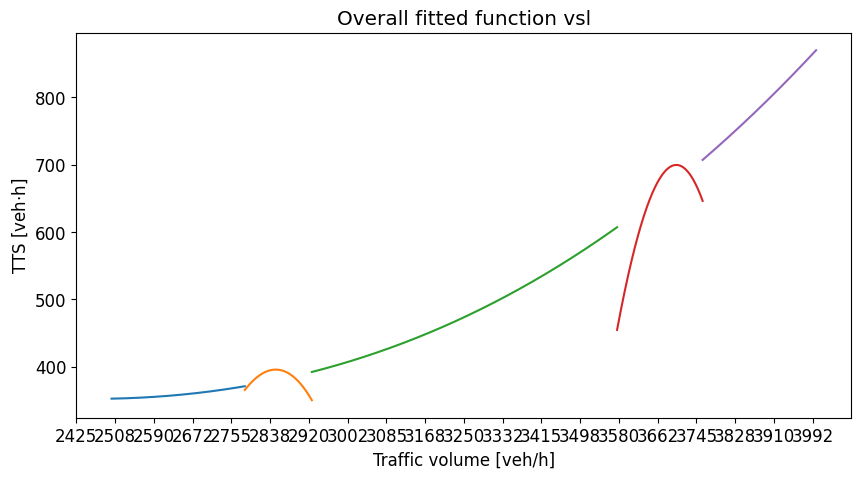

In [5]:
import re
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
from global_settings import lgs, mgs


all_fit_intervals_data = logger.all_fit_intervals_data
remaining_unfit_intervals = logger.remaining_unfit_intervals
_, ax = plt.subplots(figsize=(10, 5))

# Plot FI intervals with their fitting functions
for element in all_fit_intervals_data:
    interval = element['interval']
    fitting_function_str = element['fitting_function']

    # Convert the string into a function
    terms = re.findall(
        r'([+-]?\s*\d+\.?\d*(?:e[+-]?\d+)?)(x\^\d+)?', fitting_function_str.replace(' ', ''))
    coefficients = [0] * 10  # Initialize a list of 10 zeros
    for term in terms:
        coef = float(term[0])
        if term[1]:  # If there is an 'x' term
            exponent = int(term[1][2:])  # Get the exponent
            while len(coefficients) <= exponent:  # Expand the list if needed
                coefficients.append(0)
            # Assign the coefficient to the corresponding position in the list
            coefficients[exponent] = coef
        else:  # If there is no 'x' term, it's the constant term
            coefficients[0] = coef
    # Reverse the list to match the order expected by np.poly1d
    fitting_function = np.poly1d(coefficients[::-1])

    # Adjust the number of points as needed
    x = np.linspace(interval[0], interval[1], 400)
    y = fitting_function(x)
    ax.plot(x, y, label=f'Interval: {interval}')
    #plt.ylim([-100, 100])
    ax.set_xticks(np.arange(*ax.get_xlim(),
                            (ax.get_xlim()[1] - ax.get_xlim()[0]) / 20))

for element in remaining_unfit_intervals:
    ax.axvspan(*element['interval'], color='gray',
               alpha=0.3, label='unfit Interval')
plt.title("Overall fitted function vsl")
plt.xlabel('Traffic volume [veh/h]')
plt.ylabel('TTS [veh$\cdot$h]')
plt.savefig(f"total_function-vsl.pdf", format='pdf')



In [7]:
save_object(logger.all_fit_intervals_data,"logger-fit.pkl")
save_object(logger.remaining_unfit_intervals,"logger-unfit.pkl")

In [8]:
remaining_unfit_intervals

[]

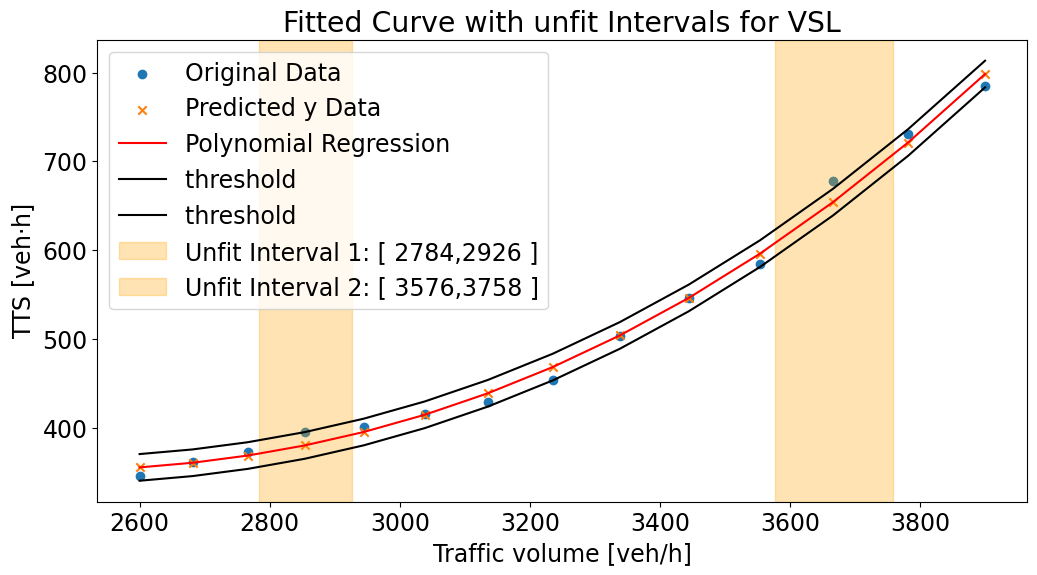

In [9]:
import matplotlib
from global_settings import vfs
import pickle
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
# vsl = validator_controller_vsl
# nvsl = validator_controller_novsl

# Uncomment to read the validator_controller object from file to plot curves
# Figures for the paper
#vsl = pickle.load(open("vc_novsl_loop-1-20240605-173339.pkl", "rb"))
vsl = pickle.load(open("vc_vsl_loop-1-20240605-173349.pkl", "rb"))
# nvsl = pickle.load(open("vc_vsl_loop-3-20240602-230447.pkl", "rb"))

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


plt.rcParams.update({'font.size': 17})

# Plot for vsl
#for controller in [validator_controller_vsl,validator_controller_novsl]:
# controller= validator_controller_novsl
#    print(f"X values and Y values {controller.x_values}{controller.y_values} predicted values {controller.predicted_values}")
#    plt.scatter(controller.x_values, controller.y_values, label=f'Original Data ')
#    plt.scatter(controller.x_values, controller.predicted_values, label=f'Predicted y Data ', marker='x')
#    plt.plot(controller.fitted_curve[2], controller.fitted_curve[1], color='red', label=f'Polynomial Regression')
#    plt.plot(controller.fitted_curve[2], controller.fitted_curve[1] + vfs["threshold_y_fitting"], color='black', label=f'threshold ')
#    plt.plot(controller.fitted_curve[2], controller.fitted_curve[1] - vfs["threshold_y_fitting"], color='black', label=f'threshold ')

plt.scatter(vsl.x_values, vsl.y_values, label=f'Original Data ')
plt.scatter(vsl.x_values, vsl.predicted_values, label=f'Predicted y Data ', marker='x')
plt.plot(vsl.fitted_curve[2], vsl.fitted_curve[1], color='red', label=f'Polynomial Regression')
plt.plot(vsl.fitted_curve[2], vsl.fitted_curve[1] + vfs["threshold_y_fitting"], color='black', label=f'threshold ')
plt.plot(vsl.fitted_curve[2], vsl.fitted_curve[1] - vfs["threshold_y_fitting"], color='black', label=f'threshold ')

# plt.scatter(nvsl.x_values, nvsl.y_values, label=f'Original Data ')
# plt.scatter(nvsl.x_values, nvsl.predicted_values, label=f'Predicted y Data ', marker='x')
# plt.plot(nvsl.fitted_curve[2], nvsl.fitted_curve[1], color='blue', label=f'Polynomial Regression novsl')
#plt.plot(nvsl.fitted_curve[2], nvsl.fitted_curve[1] + vfs["threshold_y_fitting"], color='black', label=f'threshold ')
#plt.plot(nvsl.fitted_curve[2], nvsl.fitted_curve[1] - vfs["threshold_y_fitting"], color='black', label=f'threshold ')
count = 0
for start, end in vsl.unfit_interval:
    count += 1
    plt.axvspan(start, end, color='orange',alpha=0.3, label=f'Unfit Interval {count}: [ {round(start)},{round(end)} ]')


plt.xlabel('Traffic volume [veh/h]')
plt.ylabel('TTS [veh$\cdot$h]')
plt.title(f'Fitted Curve with unfit Intervals for VSL')
plt.legend()
#plt.show()
plt.savefig(f"test.pdf", format='pdf')

In [3]:
import numpy
numpy.float64(10985000000)

10985000000.0

In [4]:
numpy.finfo(numpy.float64)

finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)